In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sys
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.ClassifierModel import ClassifierModel
from src.utils.REPDataset import REPDataset, plot_perturbation_layers
from src.utils.perturbations import *

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

In [18]:
mnist_trainset = datasets.MNIST(root=ROOT+"src/data", train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root=ROOT+"src/data", train=False, download=True, transform=ToTensor())

# Extract the data and labels from the MNIST train set
train_data = mnist_trainset.data.numpy()
train_labels = mnist_trainset.targets.numpy()

# Define the perturbation functions
perturbations = [
    gaussian_noise_perturbation(std=2.5),
    gaussian_noise_perturbation(std=5),
    laplacian_noise_perturbation(scale=2),
    laplacian_noise_perturbation(scale=4),
    lp_norm_perturbation(epsilon=50, p=2),
    lp_norm_perturbation(epsilon=100, p=2),
    # lpips_perturbation(std=5),
]

# Set the number of training and validation examples
N_training_examples = 55000
N_validation_examples = 5000

# Set the random seed for reproducibility
random_seed = 1
np.random.seed(random_seed)

# Create indices for the train set
train_indices = np.arange(len(train_data))
np.random.shuffle(train_indices)  # Shuffle the indices randomly

# Split the indices into training and validation sets
training_indices = train_indices[:N_training_examples]
validation_indices = train_indices[N_training_examples:N_training_examples+N_validation_examples]

# Create an instance of the REPDataset for the train set
rep_trainset = REPDataset(train_data, train_labels, training_indices, train_indices=training_indices, 
                          test_indices=validation_indices, perturbations=perturbations, 
                          include_original=True, shuffle=False)
# Extract the data and labels from the MNIST test set
test_data = mnist_testset.data.numpy()
test_labels = mnist_testset.targets.numpy()

# Create indices for the test set
test_indices = np.arange(len(test_data))

# Create an instance of the REPDataset for the test set (without perturbations)
rep_testset = REPDataset(test_data, test_labels, test_indices, train_indices=[], 
                         test_indices=test_indices)

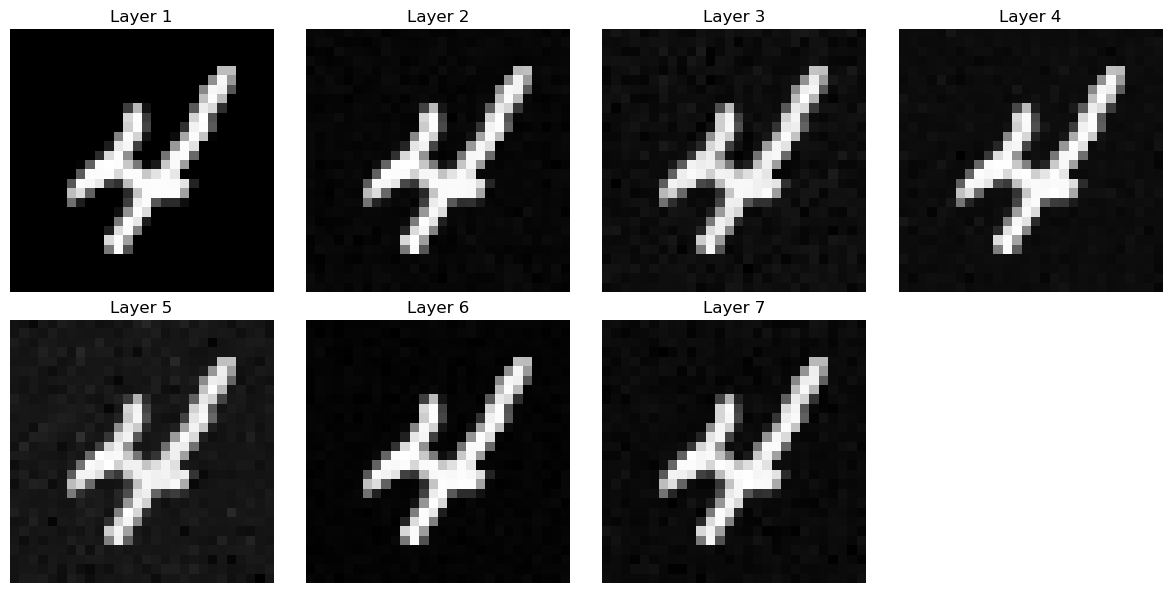

In [19]:
plot_perturbation_layers(rep_trainset, 9)

In [22]:
# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))

# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 32] # must start with a 1 and be at least length--2
linear_sizes = [64, 32]
kernel = 3
model = ClassifierModel(channel_widths, linear_sizes, kernel, pool_fcn, num_perturbations=rep_trainset.multiplicity, num_classes=10)

In [23]:
config = {'lr': 1e-3,
          'n_epochs': 5,
          'batch_size': 64}
verbose = True # print metrics during training, False for no printing
model.train_model(rep_trainset, training_indices, validation_indices, config)

Epoch 1/5: (Train) Loss = 1.3149e+00, Acc = 0.5463, (Val) Loss = 1.1283e+00, Acc = 0.5974
Epoch 2/5: (Train) Loss = 6.5156e-01, Acc = 0.7830, (Val) Loss = 6.2732e-01, Acc = 0.7824
Epoch 3/5: (Train) Loss = 4.8335e-01, Acc = 0.8405, (Val) Loss = 4.6242e-01, Acc = 0.8544
Epoch 4/5: (Train) Loss = 4.1401e-01, Acc = 0.8639, (Val) Loss = 3.7710e-01, Acc = 0.8694
Epoch 5/5: (Train) Loss = 3.6231e-01, Acc = 0.8820, (Val) Loss = 3.8832e-01, Acc = 0.8698


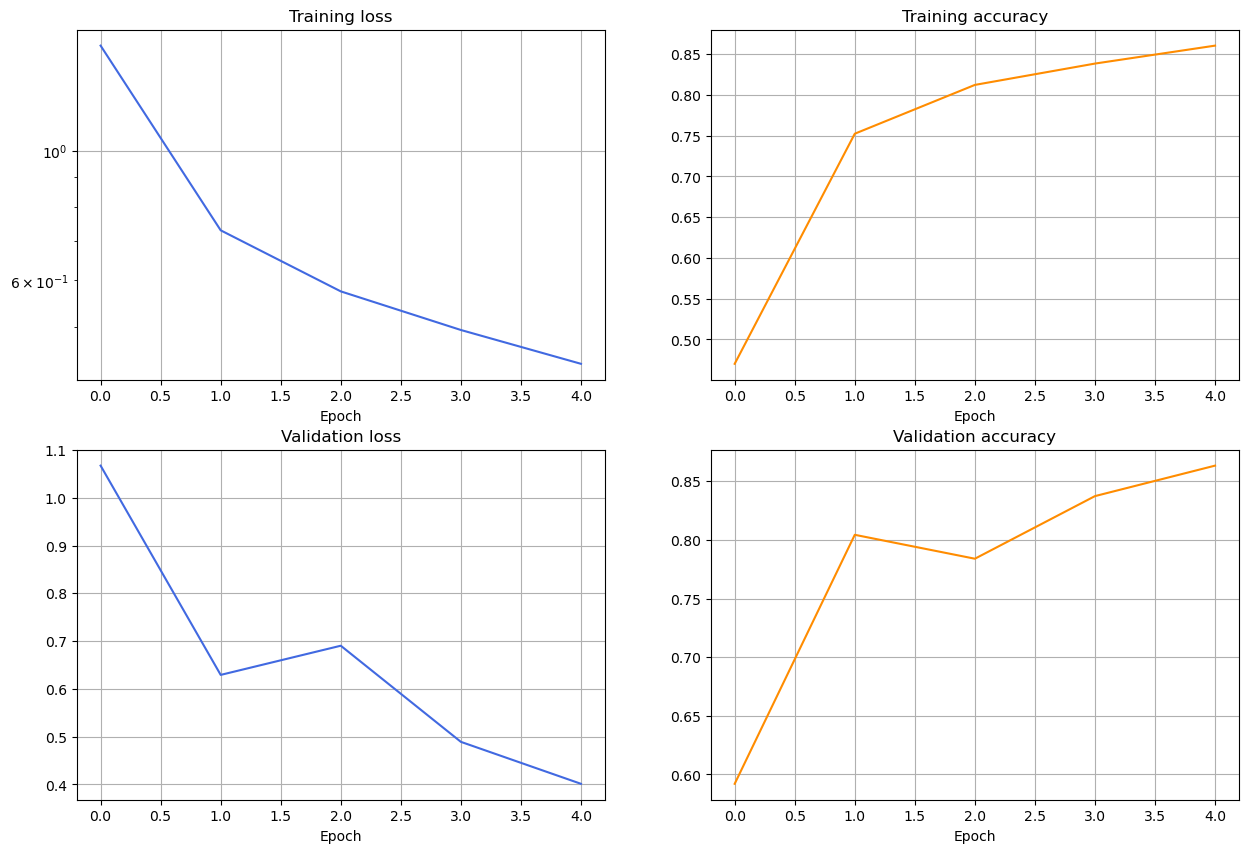

In [16]:
# plot training/validation loss and accuracy over training time
model.plot_model_results()

In [21]:
model_name = 'no_perturbations_01'
model.save_model(ROOT + 'src/models/' + model_name + '.pt')